**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200  

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
179,"В Корее появился телефон с фотопринтером Южная Корея продолжает удивлять.\nНакануне на нескольких профильных сайтах, описывающих достижения местной\nпромышленности, появились сообщения о совершенн...",tech
983,"Лукашенко примет польского сенатора, которого 4 года назад не пустили в Беларусь\n\n3 декабря 2016 в 17:13\n\nTUT.BY\n\nПредседатель польского сената Станислав Карчевски во главе делегации посетит...",politics


---

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian') )

In [8]:
%%time 

data['text_clean'] = data['text'].str.lower() # приведение в lowercase

# замена символов-разделителей (-,_) на пробел
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'_', ' ', s))

# замена цифр
data['text_clean'] = data['text_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' ', s))

# делим строки на слова (токенизация)
data['text_clean'] = data['text_clean'].apply(lambda t: [ w.strip() for w in t.split() if len(w.strip())>2 ] )

# удаление лишних слов 
data['text_clean'] = data['text_clean'].apply(lambda t:[w for w in t if w not in stopwords])

# стемминг, выделение основы слова
# data['text_clean'] = data['text_clean'].apply( lambda t: Stemmer('russian').stemWords(t) )
data['text_clean'] = data['text_clean'].apply(lambda t:[ SnowballStemmer('russian').stem(w) for w in t if w])


CPU times: user 18.8 s, sys: 52 ms, total: 18.9 s
Wall time: 18.9 s


In [9]:
data['text_clean'] = data['text_clean'].apply(lambda t:' '.join(t))

In [10]:
data[['text_clean']].sample(2)

,text_clean
499,савченк обвин росс готовн дойт великобритан декабр рбк фот депутат верховн рад надежд савченк счита запад станет вмешива росс останов украин устро полномасштабн вторжен котор законч великобритан т...
1581,москв декабр настоя врем росс полност готов нормализац отношен япон заяв президент владимир путин подчеркнув отсутств мирн договор восточн сосед явля анахронизм котор след устран хот полн нормализ...


##  CountVectorizer + TF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tf = TfidfVectorizer(use_idf=True,norm='l2')
# tf = TfidfVectorizer(use_idf=False,norm='l2')

tf.fit( data['text_clean'] )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
len(tf.vocabulary_)

34798

## формируем датасеты

In [14]:
X = tf.transform( data['text_clean'] )
X.shape

(3196, 34798)

In [15]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [16]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 34798), (319,), (2877, 34798), (2877,))

## обучаем

In [18]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.19,
       validation_fraction=0.1, verbose=0, warm_start=False)

## тестируем

In [19]:
o = clf.predict(X_train)

In [20]:
accuracy_score(y_train,o)

1.0

---

In [21]:
o = clf.predict(X_test)

In [22]:
accuracy_score(y_test,o)

0.7841501564129302

In [23]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       227
           1       0.79      0.84      0.82       319
           2       0.65      0.86      0.74       240
           3       0.44      0.22      0.29        86
           4       0.86      0.83      0.85       396
           5       0.80      0.91      0.85       542
           6       0.42      0.57      0.49        58
           7       0.58      0.37      0.45        41
           8       0.74      0.96      0.84       200
           9       0.60      0.26      0.37       133
          10       0.86      0.96      0.90       340
          11       0.87      0.64      0.73       262
          12       0.67      0.12      0.21        33

   micro avg       0.78      0.78      0.78      2877
   macro avg       0.71      0.64      0.64      2877
weighted avg       0.78      0.78      0.77      2877



---

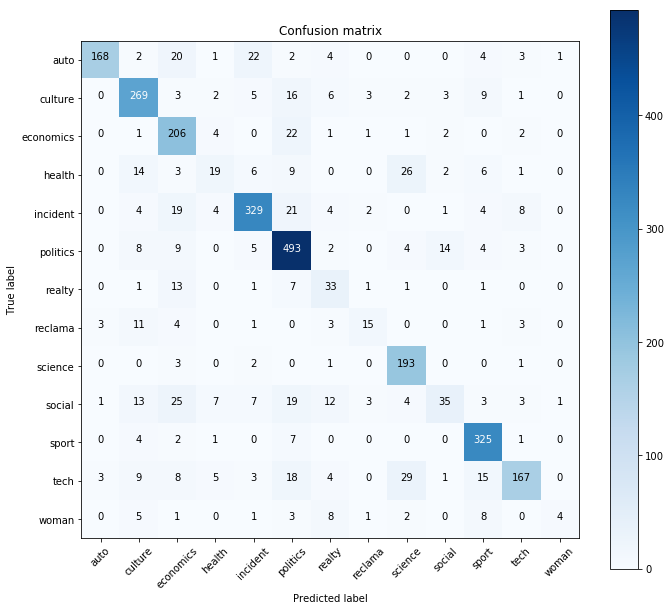

In [24]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [25]:
o = clf.predict(X)

In [26]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [27]:
i = np.random.randint(len(data))
print('tag:',data.iloc[i,1])
print('predict:',labels_inv[o[i]])
print('- - - - - - - - - - - - - - - - - - \n')
print(data.iloc[i,0])

tag: economics
predict: economics
- - - - - - - - - - - - - - - - - - 

"Газпром нефть" и иранская NIOC подписали соглашение о сотрудничестве, сообщается в твиттере Минэнерго РФ.

Как сообщает иранское агентство Shana, речь идет о партнерстве на двух месторождениях - Шангуле и Чешмех-Хош.
